Wczytanie wyczyszconych danych

In [23]:
import ast
import pandas as pd

In [24]:
news = pd.read_csv('../cleaned_datasets/fake_and_real_news.csv', sep='\t', encoding='utf-8')
news['text_clean_tokens'] = news['text_clean_tokens'].apply(ast.literal_eval)
news = news.dropna(how="any", axis=0)
news

,label,text,text_clean_tokens,text_clean,length
0,0,"As U.S. budget fight looms, Republicans flip t...","[us, budget, fight, loom, republican, flip, fi...",us budget fight loom republican flip fiscal sc...,2949
1,0,U.S. military to accept transgender recruits o...,"[us, militari, accept, transgend, recruit, mon...",us militari accept transgend recruit monday pe...,2637
2,0,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, us, republican, senat, let, mr, muell...",senior us republican senat let mr mueller job ...,1789
3,0,FBI Russia probe helped by Australian diplomat...,"[fbi, russia, probe, help, australian, diploma...",fbi russia probe help australian diplomat tipo...,1616
4,0,Trump wants Postal Service to charge 'much mor...,"[trump, want, postal, servic, charg, much, ama...",trump want postal servic charg much amazon shi...,3237
...,...,...,...,...,...
44893,1,McPain: John McCain Furious That Iran Treated ...,"[mcpain, john, mccain, furious, iran, treat, u...",mcpain john mccain furious iran treat us sailo...,2062
44894,1,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,"[justic, yahoo, settl, email, privaci, classac...",justic yahoo settl email privaci classact lawy...,1038
44895,1,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,"[sunnistan, us, alli, ‘, safe, zone, ’, plan, ...",sunnistan us alli ‘ safe zone ’ plan territori...,14880
44896,1,How to Blow $700 Million: Al Jazeera America F...,"[blow, million, jazeera, america, final, call,...",blow million jazeera america final call quit c...,1604


Wizualizacja tokenów

In [25]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

wiadomości faktyczne

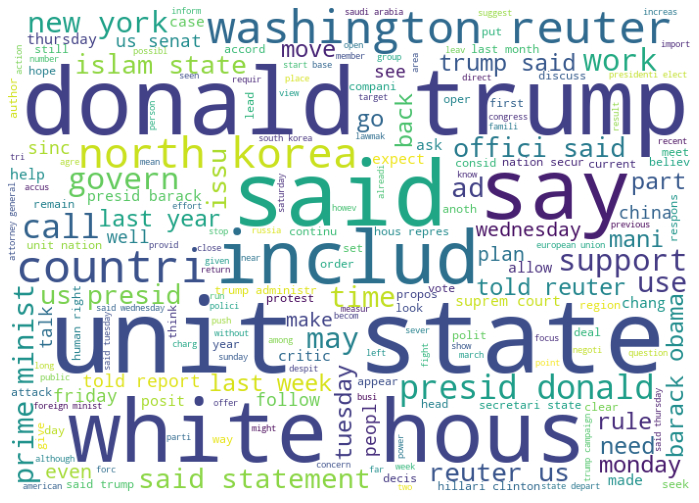

In [26]:
real_news_word_cloud = WordCloud(
	width=700,
	height=500,
	background_color='white',
)
real_news_word_cloud.generate(' '.join(text for text in news.loc[news['label'] == 0, 'text_clean']))
plt.figure(figsize=(15, 9))
plt.axis("off")
plt.imshow(real_news_word_cloud)
plt.show()

fake newsy

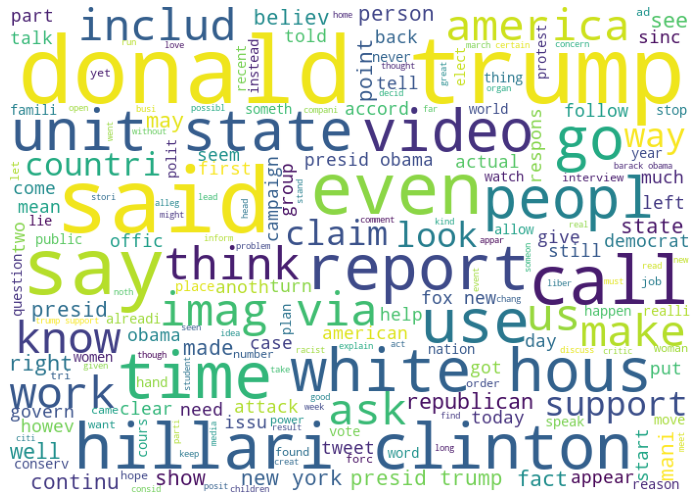

In [27]:
fake_news_word_cloud = WordCloud(
	width=700,
	height=500,
	background_color='white',
)
fake_news_word_cloud.generate(' '.join(text for text in news.loc[news['label'] == 1, 'text_clean']))
plt.figure(figsize=(15, 9))
plt.axis("off")
plt.imshow(fake_news_word_cloud)
plt.show()

Wektoryzacja

In [28]:
x = news['text_clean']
y = news['label']

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=1337)

count_vectorizer = CountVectorizer(
	stop_words='english',
	ngram_range=(1, 2),
	max_features=100
)

x_train_count_matrix = count_vectorizer.fit_transform(x_train)
x_test_count_matrix = count_vectorizer.transform(x_test)

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

x_train_tfidf = tfidf_transformer.fit_transform(x_train_count_matrix)
x_test_tfidf = tfidf_transformer.transform(x_test_count_matrix)

Modelowanie

In [31]:
# multinomial bayes

from sklearn.naive_bayes import MultinomialNB
multinomial_nb = MultinomialNB()
multinomial_nb.fit(x_train_tfidf, y_train)
y_pred_class = multinomial_nb.predict(x_test_tfidf)
y_pred_prob = multinomial_nb.predict_proba(x_test_count_matrix)[:, 1]

In [32]:
from sklearn import metrics
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_class).ravel()
print(tp)
print(fp)
print(fn)
print(tn)
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.recall_score(y_test, y_pred_class))
print(metrics.precision_score(y_test, y_pred_class))
print(metrics.f1_score(y_test, y_pred_class))

4199
276
496
4007
0.9140120294052128
0.8943556975505857
0.9383240223463687
0.9158124318429661


In [33]:
# svm
from sklearn import svm
svm = svm.SVC()
svm.fit(x_train_tfidf, y_train)
y_pred_class = svm.predict(x_test_tfidf)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_class).ravel()
print(tp)
print(fp)
print(fn)
print(tn)
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.recall_score(y_test, y_pred_class))
print(metrics.precision_score(y_test, y_pred_class))
print(metrics.f1_score(y_test, y_pred_class))

4652
26
43
4257
0.9923145466696369
0.9908413205537806
0.9944420692603677
0.9926384295316333


In [34]:
# knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train_tfidf, y_train)
y_pred_class = knn.predict(x_test_tfidf)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_class).ravel()
print(tp)
print(fp)
print(fn)
print(tn)
print(metrics.accuracy_score(y_test, y_pred_class))
print(metrics.recall_score(y_test, y_pred_class))
print(metrics.precision_score(y_test, y_pred_class))
print(metrics.f1_score(y_test, y_pred_class))

4030
251
665
4032
0.8979728224548897
0.858359957401491
0.9413688390562952
0.8979500891265596


Tokenizacja lstm

In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(news['text_clean'])
total_words = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(news['text_clean'])
max_sequence_len = min(max(len(seq) for seq in sequences), 100)
padded_sequences = pad_sequences(
	sequences,
	max_sequence_len,
	padding='pre'
)
x_lstm = padded_sequences
y_lstm = news['label']
x_lstm_train, x_lstm_test, y_lstm_train, y_lstm_test = train_test_split(x_lstm, y_lstm, train_size=0.8, stratify=y_lstm, random_state=1337)

KeyboardInterrupt: 

In [ ]:
from keras import Sequential
from keras import layers
# lstm
model = Sequential()
model.add(layers.Embedding(input_dim=total_words, output_dim=64, input_length=max_sequence_len))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(100))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(
    x_lstm_train,
    y_lstm_train,
    epochs = 5,
    batch_size = 16,
	validation_data = (x_lstm_test, y_lstm_test),
)

In [ ]:
model.save('fake_news_model.h5')

In [ ]:
y_prediction = model.predict(x_lstm_test)
y_prediction[y_prediction <= 0.5] = 0
y_prediction[y_prediction > 0.5] = 1
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_prediction).ravel()
print(tp)
print(fp)
print(fn)
print(tn)
print(metrics.accuracy_score(y_test, y_prediction))
print(metrics.recall_score(y_test, y_prediction))
print(metrics.precision_score(y_test, y_prediction))
print(metrics.f1_score(y_test, y_prediction))